In [ ]:
!pip install wget

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# the data is downloaded from the original source, ie, 
# http://gigadb.org/dataset/view/id/100295 (scroll down to Files tab, then click on '(FTP-Site)')

# we use wget library to download from the ftp server
# can be download using pip: pip install wget

import wget
import pandas as pd
import numpy as np
import os
import scipy.io

def download_mat(subjects):
  urls = []
  nums = 53
  left = []
  right = []
  event_markers = []
  for i in range(len(subjects)):
    sub = subjects[i]
    urls.append('ftp://parrot.genomics.cn/gigadb/pub/10.5524/100001_101000/100295/mat_data/' + sub)
    #print(urls)
    wget.download(urls[i], os.path.join('/content', sub))

  # ---- Following code is for reading the mat file and extracting that data we need: -------
    #print('Subject {} mat file downloaded! Starting to load the .npy files'.format(sub[1:3]))
    
    subject_i = scipy.io.loadmat('/content/' + sub)
    # how subject.mat files are structured is desccribed here: 
    # https://academic.oup.com/gigascience/article/6/7/gix034/3796323

    left.append(subject_i['eeg']['imagery_left'][0][0][:64])
    right.append(subject_i['eeg']['imagery_right'][0][0][:64])
    event_markers.append(subject_i['eeg']['imagery_event'][0][0][0])

    # print(left.shape, event_markers.shape) # (64, 358400) (358400,)

    df_left = pd.DataFrame(left[i]).T.rename(columns = lambda x: 'left'+str(x))
    df_right = pd.DataFrame(right[i]).T.rename(columns = lambda x: 'right'+str(x))
    markers = pd.Series(event_markers[i])

    df = df_left.join(df_right)
    df['mark'] = markers

    ind = list(df[df['mark'] == 1].index)
    ind = ind + [358399]
    intervals = list(zip(ind[:-1], ind[1:]))

    dfset_left = []
    dfset_right = []
    for start, end in intervals[:-1]:
        dfset_left.append(df.loc[start:end-1, 'left0':'left63'])
        dfset_right.append(df.loc[start:end-1, 'right0':'right63'])

    bci_left = []
    for df in dfset_left:
        bci_left.append(df.values.T)
    bci_left = np.array(bci_left)
    np.save('bci_imagery_left_sub{}.npy'.format(sub[1:3]), bci_left)

    bci_right = []
    for df in dfset_right:
        bci_right.append(df.values.T)
    bci_right = np.array(bci_right)
    np.save('bci_imagery_right_sub{}.npy'.format(sub[1:3]), bci_right)

    # print(bci_left.shape, bci_right.shape) # (99, 64, 3584) (99, 64, 3584)

# Example testing   
# Specify relevant number of files in 'number_of_matfiles'

subjs = []
num_of_matfiles = 21
for i in range(1, num_of_matfiles):
  if i >= 1 and i <= 9:
    num_subj = '{}'.format(i).zfill(2)
    mat_file = 's' + num_subj + '.mat'
    subjs.append(mat_file)
  else:
    mat_file = 's{}.mat'.format(i)
    subjs.append(mat_file)

download_mat(subjs)

In [ ]:
import numpy as np
import os
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

options = ['left', 'right']
test_size = 0.3

try:
  os.mkdir('data/')
  os.mkdir('data/left')
  os.mkdir('data/right')
  os.mkdir('test_data/')
  os.mkdir('test_data/left')
  os.mkdir('test_data/right')
  os.mkdir('validation_data/')
  os.mkdir('validation_data/left')
  os.mkdir('validation_data/right')
except:
  OSError

left_imagery = []  # list of left .npy files
right_imagery = []  # list of right .npy files
data_left = []  # list of loaded content of left .npy files
data_right = []  # list of loaded content of right .npy files

for filenames in os.listdir('/content'):
  if filenames.startswith('bci_imagery_left'):
    data_l = np.load(filenames)
    data_left.append(data_l)
    left_imagery.append(filenames)
  elif filenames.startswith('bci_imagery_right'):
    data_r = np.load(filenames)
    data_right.append(filenames)
    right_imagery.append(filenames)

for actions in options:
  if actions == 'left':
    train_left = []
    test_left = []

    num_test = int(len(left_imagery))
    indices = list(range(num_test))
    np.random.shuffle(indices)
    #print(indices)
    split = int(test_size * len(left_imagery))
    #print(split)
    train_idx, test_idx = indices[split:], indices[:split]

    for indices in train_idx:
      train_left.append(left_imagery[indices])
    for indices in test_idx:
      test_left.append(left_imagery[indices])

    #print(train_left)
    #print('\n')
    #print(test_left)

    for i in range(len(train_left)):
      shutil.copy(train_left[i], 'data/left')
    for j in range(len(test_left)):
      shutil.copy(test_left[j], 'test_data/left')

  elif actions == 'right':
    train_right = []
    test_right = []

    num_test = int(len(right_imagery))
    indices = list(range(num_test))
    np.random.shuffle(indices)
    split = int(test_size * len(right_imagery))
    train_idx, test_idx = indices[split:], indices[:split]

    for indices in train_idx:
      train_right.append(right_imagery[indices])
    for indices in test_idx:
      test_right.append(right_imagery[indices])

    for i in range(len(train_right)):
      shutil.copy(train_right[i], 'data/right')
    for j in range(len(test_right)):
      shutil.copy(test_right[j], 'test_data/right')

# List of training data + labels
combined_data = [] 

# Create training data
l = []
r = []

for item in os.listdir('data/left'):
  datal = np.load(os.path.join('data/left', item))
  for item in datal:
    l.append(item)
for datas in l:
  combined_data.append([datas, [1, 0]])  # [1, 0] for left

for item in os.listdir('data/right'):
  datar = np.load(os.path.join('data/right', item))
  for item in datar:
    r.append(item)
for datas in r:
  combined_data.append([datas, [0, 1]])  # [0, 1] for right

# Create testing data
l1 = []
r1 = []

# List of testing data + labels
combined_data_test = []

for item in os.listdir('test_data/left'):
  datal = np.load(os.path.join('test_data/left', item))
  for item in datal:
    l1.append(item)
for datas in l1:
  combined_data_test.append([datas, [1, 0]])

for item in os.listdir('test_data/right'):
  datar = np.load(os.path.join('test_data/right', item))
  for item in datar:
    r1.append(item)
for datas in r1:
  combined_data_test.append([datas, [0, 1]])

train_x = []
train_y = []
for x, y in combined_data:
  train_x.append(x)
  train_y.append(y)

test_x = []
test_y = []
for x, y in combined_data_test:
  test_x.append(x)
  test_y.append(y)

train_x = np.array(train_x).reshape((-1, 64, 3584))
train_y = np.array(train_y)
test_x = np.array(test_x).reshape((-1, 64, 3584))
test_y = np.array(test_y)

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1228, 64, 3584), (1228, 2), (931, 64, 3584), (931, 2))

In [ ]:
train_labels = []
for i in range(train_y.shape[0]):
  if train_y[i, 0] == 0 and train_y[i, 1] == 1:
    train_labels.append(1)  # Right.
  else:
    train_labels.append(0)  # Left.

test_labels = []
for i in range(test_y.shape[0]):
  if test_y[i, 0] == 0 and test_y[i, 1] == 1:
    test_labels.append(1)  # Right.
  else:
    test_labels.append(0)  # Left.

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

**Train data**: 1010 trials, each with 64 channels.\
**Test data**: 426 trials, each with 64 channels.

**Train labels, Test labels**: 0 or 1, for each trial.

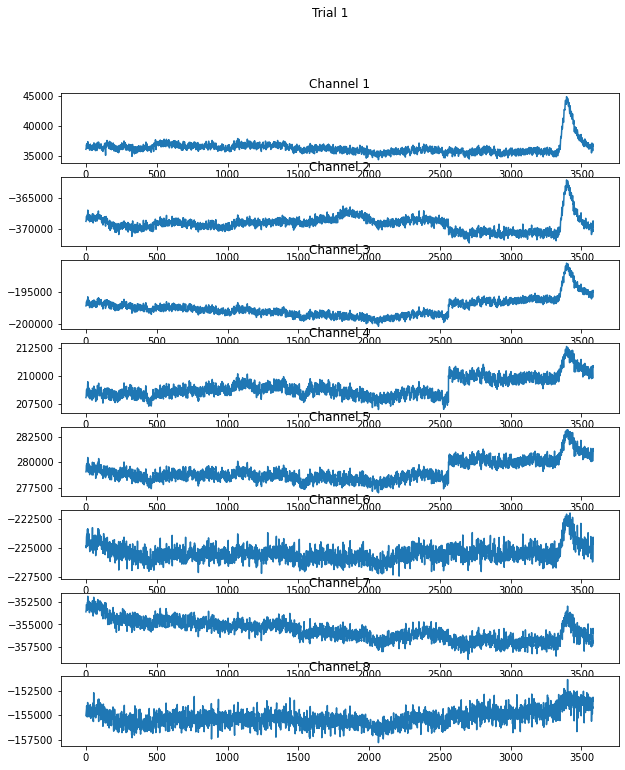

In [ ]:
fig, ax = plt.subplots(8, figsize=(10, 12))

for i in range(8):
  ax[i].plot(train_x[0][i]);
  ax[i].set_title(f"Channel {i+1}");

fig.suptitle("Trial 1");
# plt.tight_layout();

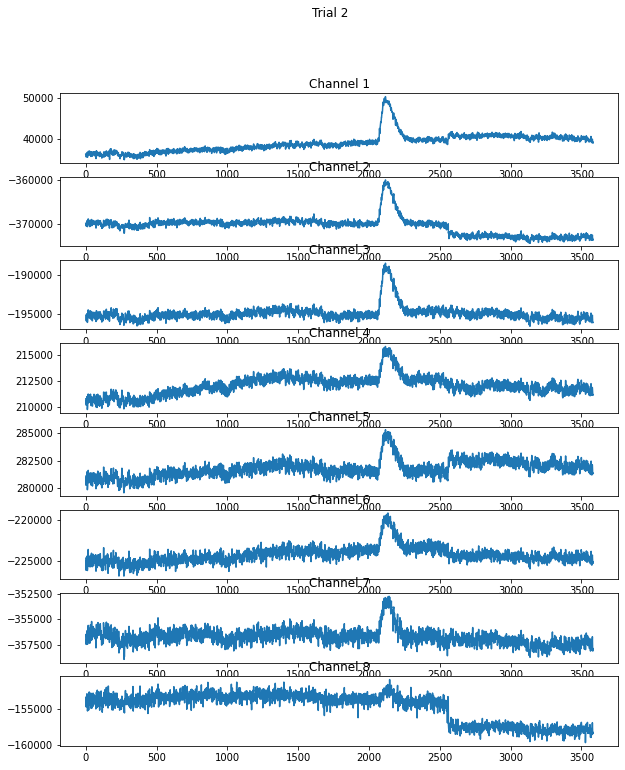

In [ ]:
fig, ax = plt.subplots(8, figsize=(10, 12))

for i in range(8):
  ax[i].plot(train_x[1][i]);
  ax[i].set_title(f"Channel {i+1}");

fig.suptitle("Trial 2");
# plt.tight_layout();

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
time_series_length, num_channels, num_trials = train_x.shape  # 3584, 64, 1010.

# Select only the first channel.
train_x = train_x[:, 0, :]
test_x = test_x[:, 0, :]

# Scale values.
robust_scaler = RobustScaler()
trainx = robust_scaler.fit_transform(train_x)
testx = robust_scaler.fit_transform(test_x)

In [ ]:
trainx.shape, testx.shape  # (num_trials, num_points_for_each_trial)

((1228, 3584), (931, 3584))

In [ ]:
import xgboost as xgb

In [ ]:
train = xgb.DMatrix(trainx, label=train_labels)
test = xgb.DMatrix(testx, label=test_labels)

In [ ]:
# Define parameters for XGBoost classifier.
params = {}

# The values have been selected using cross validation on a subset of the data. Analysis in cv_analysis.md.

# Booster parameters
params["eta"]              = 0.01 # Learning rate
params["max_depth"]        = 12  # Maximum depth of tree
params["subsample"]        = 0.8 # Fraction of events to train the tree on
params["colsample_bytree"] = 0.8 # Fraction of features to train the tree on
params["min_child_weight"] = 13 # Minimum weight required to create a new node in the tree

# Learning parameters
params["objective"]   = "binary:logistic" # Objective function (two classes for which a score needs to be output)
params["eval_metric"] = "error"           # Evaluation metric for cross validation
params = dict(list(params.items()) + [("eval_metric", "log-loss"), ("eval_metric", "rmse")])

In [ ]:
num_trees = 300
booster = xgb.train(params, train, num_boost_round=num_trees) # Took 18min 44s

In [ ]:
model_path = "xgbbost_model.txt"
booster.save_model(fname=model_path)

In [ ]:
predictions = booster.predict(test)

In [ ]:
predictions

array([0.5226891 , 0.52029735, 0.51510876, 0.52029735, 0.52029735,
       0.51820797, 0.51820797, 0.51820797, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.51820797, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.5249772 , 0.5094972 ,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046174,
       0.52046174, 0.52046174, 0.52046174, 0.52046174, 0.52046

In [ ]:
evaluation = booster.eval(test)
evaluation

'[0]\teval-rmse:0.471438'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

In [ ]:
final_predictions = np.array([round(pred) for pred in predictions])

In [ ]:
confusion_matrix(test.get_label(), final_predictions)

array([[165, 251],
       [109, 406]])

In [ ]:
accuracy_score(test.get_label(), final_predictions)

0.6133190118152524

In [ ]:
print(classification_report(test.get_label(), final_predictions))

              precision    recall  f1-score   support

         0.0       0.60      0.40      0.48       416
         1.0       0.62      0.79      0.69       515

    accuracy                           0.61       931
   macro avg       0.61      0.59      0.59       931
weighted avg       0.61      0.61      0.60       931

